In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.1


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OData,779.918301,194.979575,295.912835,4
Azure Developer Associate,841.197798,19.562739,50.044348,43
Todd Ideas,1208.457448,80.563830,169.200181,15
Python,1283.652205,27.311749,41.591453,47
Email Auth and Security,1638.976894,136.581408,498.771240,12
SharePoint,1900.861552,158.405129,599.238946,12
Audit Report Tracker (Sharepoint List),2038.859334,156.835333,398.042664,13
Azure Functions + Visual Studio,2210.738309,157.909879,506.604597,14
Debugging in VS Code,2309.562237,115.478112,284.485449,20
IW Migration,2381.081230,170.077231,483.956776,14


# Histogram

79399.60


<Axes: >

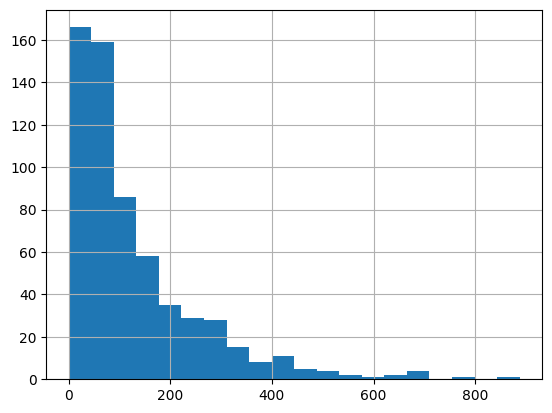

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [14]:
n = 1
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 615


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Vocab,Boustrophedonic\nadjective\nSPA: boo-struh-fee...,c778949e7f683ddbc9ae9910ad5c565c,-887.696633,108.932048,-887.696633,8060.971563,0.547497,0,0
1,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,-767.868025,282.585170,-767.868025,3108.436873,0.059255,0,0
2,Azure AI Search,"If you include a skillset, you'll need to spec...",9e291c2452d2e6788d57e9973c39d8f9,-704.364977,269.044795,-704.364977,2421.403153,0.878320,0,0
3,Powershell Modules,PowerShell Gallery\n\nDefinition: The central ...,92931a76329cd1bec63d78a358648c4d,-696.206643,177.432990,-696.206643,5322.989686,0.195942,0,0
4,Logging in Python,Q: In TimedRotatingFileHandler from the loggin...,d53f8f76d58dd27e3ded74f30a190cb4,-695.834487,120.767633,-695.834487,5917.614005,0.532283,0,0
5,PnP Powershell,SharePoint REST API\nA set of web services pro...,143745e569af1c6a779118128bf12b60,-674.751593,193.618752,-674.751593,7357.512573,0.590890,0,0
6,SharePoint,How can you retrieve the metadata of a specifi...,a9bef1ae5a68637d2ee73d72c0aa7e47,-599.238946,158.405129,-599.238946,1900.861552,0.493097,0,0
7,Azure Functions + Visual Studio,ASP.NET includes a variety of built-in securit...,22f41dbaa7f06bfee2174c4754c8f951,-506.604597,157.909879,-506.604597,2210.738309,0.395545,0,0
8,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,-498.771240,136.581408,-498.771240,1638.976894,0.270600,0,0
9,IW Migration,Linked Server (SQL Server)\nA configuration th...,fa3ffa381d1fcef8e1ca182752dc366d,-483.956776,170.077231,-483.956776,2381.081230,0.099221,0,0


## Card Count

In [15]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Vocab,Boustrophedonic\nadjective\nSPA: boo-struh-fee...,c778949e7f683ddbc9ae9910ad5c565c,-887.696633,108.932048,-887.696633,8060.971563,0.547497,0,0
1,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,-767.868025,282.585170,-767.868025,3108.436873,0.059255,0,0
2,Azure AI Search,"If you include a skillset, you'll need to spec...",9e291c2452d2e6788d57e9973c39d8f9,-704.364977,269.044795,-704.364977,2421.403153,0.878320,0,0
3,Powershell Modules,PowerShell Gallery\n\nDefinition: The central ...,92931a76329cd1bec63d78a358648c4d,-696.206643,177.432990,-696.206643,5322.989686,0.195942,0,0
4,Logging in Python,Q: In TimedRotatingFileHandler from the loggin...,d53f8f76d58dd27e3ded74f30a190cb4,-695.834487,120.767633,-695.834487,5917.614005,0.532283,0,0
5,PnP Powershell,SharePoint REST API\nA set of web services pro...,143745e569af1c6a779118128bf12b60,-674.751593,193.618752,-674.751593,7357.512573,0.590890,0,0
6,SharePoint,How can you retrieve the metadata of a specifi...,a9bef1ae5a68637d2ee73d72c0aa7e47,-599.238946,158.405129,-599.238946,1900.861552,0.493097,0,0
7,Azure Functions + Visual Studio,ASP.NET includes a variety of built-in securit...,22f41dbaa7f06bfee2174c4754c8f951,-506.604597,157.909879,-506.604597,2210.738309,0.395545,0,0
8,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,-498.771240,136.581408,-498.771240,1638.976894,0.270600,0,0
9,IW Migration,Linked Server (SQL Server)\nA configuration th...,fa3ffa381d1fcef8e1ca182752dc366d,-483.956776,170.077231,-483.956776,2381.081230,0.099221,0,0


In [18]:
existing_cards['age'].mean()

-129.10504046688982